In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

h = h[1:]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
# del cm_target[1,2,7,10,13]
del cm_target[13]
del cm_target[10]
del cm_target[7]
del cm_target[1:3]
del cm_target[0]

In [11]:
cm_target

['case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = np.concatenate((h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (50000, 2)
Dimension - heights of Gurney flaps:  (50000, 1)
Dimension - inclination(beta):  (50000, 1)
Dimension - x:  (50000, 3)
Dimension - y:  (50000, 1)


In [21]:
x[:,0] -= 10
x[:,0] /= 5

In [22]:
x[:,0]

array([0.000e+00, 2.000e-04, 4.000e-04, ..., 9.994e-01, 9.996e-01,
       9.998e-01])

In [23]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [24]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [25]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [26]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [28]:
model_directory = "D:\\TrainedModels\\20221229\\10h"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [29]:
#ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_10h_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

#ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-06,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.1,
                                          min_delta = 1e-6, min_lr=1e-05, verbose=1)

In [30]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [31]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
35/35 [==============================] - 2s 13ms/step - loss: 0.1070 - rmse: 0.3269 - val_loss: 0.0665 - val_rmse: 0.2576 - lr: 1.0000e-04
Epoch 2/10000
35/35 [==============================] - 0s 12ms/step - loss: 0.0628 - rmse: 0.2505 - val_loss: 0.0619 - val_rmse: 0.2485 - lr: 1.0000e-04
Epoch 3/10000
35/35 [==============================] - 0s 8ms/step - loss: 0.0620 - rmse: 0.2488 - val_loss: 0.0615 - val_rmse: 0.2478 - lr: 1.0000e-04
Epoch 4/10000
35/35 [==============================] - 0s 8ms/step - loss: 0.0618 - rmse: 0.2483 - val_loss: 0.0613 - val_rmse: 0.2473 - lr: 1.0000e-04
Epoch 5/10000
35/35 [==============================] - 0s 8ms/step - loss: 0.0615 - rmse: 0.2479 - val_loss: 0.0611 - val_rmse: 0.2469 - lr: 1.0000e-04
Epoch 6/10000
35/35 [==============================] - 0s 8ms/step - loss: 0.0613 - rmse: 0.2475 - val_loss: 0.0608 - val_rmse: 0.2464 - lr: 1.0000e-04
Epoch 7/10000
35/35 [==============================] - 0s 8ms/step - loss: 0.0611 - rm

35/35 [==============================] - 0s 7ms/step - loss: 0.0447 - rmse: 0.2112 - val_loss: 0.0446 - val_rmse: 0.2110 - lr: 1.0000e-04
Epoch 55/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0448 - rmse: 0.2115 - val_loss: 0.0445 - val_rmse: 0.2107 - lr: 1.0000e-04
Epoch 56/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0446 - rmse: 0.2109 - val_loss: 0.0450 - val_rmse: 0.2119 - lr: 1.0000e-04
Epoch 57/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0442 - rmse: 0.2100 - val_loss: 0.0441 - val_rmse: 0.2097 - lr: 1.0000e-04
Epoch 58/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0440 - rmse: 0.2096 - val_loss: 0.0440 - val_rmse: 0.2095 - lr: 1.0000e-04
Epoch 59/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0438 - rmse: 0.2090 - val_loss: 0.0438 - val_rmse: 0.2090 - lr: 1.0000e-04
Epoch 60/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0435 - rmse: 0.2084

35/35 [==============================] - 0s 7ms/step - loss: 0.0267 - rmse: 0.1631 - val_loss: 0.0265 - val_rmse: 0.1626 - lr: 1.0000e-04
Epoch 108/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0264 - rmse: 0.1621 - val_loss: 0.0265 - val_rmse: 0.1624 - lr: 1.0000e-04
Epoch 109/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0263 - rmse: 0.1618 - val_loss: 0.0259 - val_rmse: 0.1608 - lr: 1.0000e-04
Epoch 110/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0259 - rmse: 0.1607 - val_loss: 0.0256 - val_rmse: 0.1598 - lr: 1.0000e-04
Epoch 111/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0253 - rmse: 0.1588 - val_loss: 0.0256 - val_rmse: 0.1596 - lr: 1.0000e-04
Epoch 112/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0251 - rmse: 0.1582 - val_loss: 0.0267 - val_rmse: 0.1632 - lr: 1.0000e-04
Epoch 113/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0253 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0164 - rmse: 0.1276 - val_loss: 0.0167 - val_rmse: 0.1288 - lr: 1.0000e-04
Epoch 161/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0166 - rmse: 0.1283 - val_loss: 0.0188 - val_rmse: 0.1367 - lr: 1.0000e-04
Epoch 162/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0174 - rmse: 0.1316 - val_loss: 0.0161 - val_rmse: 0.1265 - lr: 1.0000e-04
Epoch 163/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0167 - rmse: 0.1289 - val_loss: 0.0161 - val_rmse: 0.1265 - lr: 1.0000e-04
Epoch 164/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0161 - rmse: 0.1266 - val_loss: 0.0161 - val_rmse: 0.1265 - lr: 1.0000e-04
Epoch 165/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0161 - rmse: 0.1266 - val_loss: 0.0157 - val_rmse: 0.1250 - lr: 1.0000e-04
Epoch 166/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0162 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0120 - rmse: 0.1093 - val_loss: 0.0111 - val_rmse: 0.1050 - lr: 1.0000e-04
Epoch 214/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0123 - rmse: 0.1103 - val_loss: 0.0122 - val_rmse: 0.1100 - lr: 1.0000e-04
Epoch 215/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0116 - rmse: 0.1073 - val_loss: 0.0110 - val_rmse: 0.1044 - lr: 1.0000e-04
Epoch 216/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0112 - rmse: 0.1056 - val_loss: 0.0109 - val_rmse: 0.1040 - lr: 1.0000e-04
Epoch 217/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0109 - rmse: 0.1038 - val_loss: 0.0111 - val_rmse: 0.1048 - lr: 1.0000e-04
Epoch 218/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0110 - rmse: 0.1042 - val_loss: 0.0109 - val_rmse: 0.1038 - lr: 1.0000e-04
Epoch 219/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0109 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0081 - rmse: 0.0895 - val_loss: 0.0078 - val_rmse: 0.0877 - lr: 1.0000e-04
Epoch 267/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0079 - rmse: 0.0883 - val_loss: 0.0074 - val_rmse: 0.0853 - lr: 1.0000e-04
Epoch 268/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0094 - rmse: 0.0967 - val_loss: 0.0114 - val_rmse: 0.1064 - lr: 1.0000e-04
Epoch 269/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0092 - rmse: 0.0957 - val_loss: 0.0081 - val_rmse: 0.0896 - lr: 1.0000e-04
Epoch 270/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0077 - rmse: 0.0874 - val_loss: 0.0077 - val_rmse: 0.0871 - lr: 1.0000e-04
Epoch 271/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0077 - rmse: 0.0872 - val_loss: 0.0072 - val_rmse: 0.0844 - lr: 1.0000e-04
Epoch 272/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0084 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0054 - rmse: 0.0728 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 320/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0049 - rmse: 0.0692 - val_loss: 0.0049 - val_rmse: 0.0696 - lr: 1.0000e-04
Epoch 321/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0047 - val_rmse: 0.0680 - lr: 1.0000e-04
Epoch 322/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0049 - rmse: 0.0692 - val_loss: 0.0051 - val_rmse: 0.0711 - lr: 1.0000e-04
Epoch 323/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0051 - rmse: 0.0711 - val_loss: 0.0062 - val_rmse: 0.0781 - lr: 1.0000e-04
Epoch 324/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0055 - rmse: 0.0737 - val_loss: 0.0066 - val_rmse: 0.0806 - lr: 1.0000e-04
Epoch 325/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0056 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0059 - val_rmse: 0.0762 - lr: 1.0000e-04
Epoch 373/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0043 - rmse: 0.0652 - val_loss: 0.0034 - val_rmse: 0.0572 - lr: 1.0000e-04
Epoch 374/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0040 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 375/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0044 - rmse: 0.0656 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-04
Epoch 376/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0039 - val_rmse: 0.0619 - lr: 1.0000e-04
Epoch 377/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0036 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 378/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0037 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 426/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0035 - rmse: 0.0581 - val_loss: 0.0076 - val_rmse: 0.0866 - lr: 1.0000e-04
Epoch 427/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0025 - val_rmse: 0.0487 - lr: 1.0000e-04
Epoch 428/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0532 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-04
Epoch 429/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 430/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 431/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 479/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0468 - val_loss: 0.0019 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 480/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 0.0022 - val_rmse: 0.0457 - lr: 1.0000e-04
Epoch 481/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0497 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 482/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0027 - val_rmse: 0.0509 - lr: 1.0000e-04
Epoch 483/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0019 - val_rmse: 0.0429 - lr: 1.0000e-04
Epoch 484/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0032 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0021 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 532/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0018 - val_rmse: 0.0410 - lr: 1.0000e-04
Epoch 533/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0417 - val_loss: 0.0051 - val_rmse: 0.0705 - lr: 1.0000e-04
Epoch 534/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0025 - rmse: 0.0488 - val_loss: 0.0016 - val_rmse: 0.0386 - lr: 1.0000e-04
Epoch 535/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 536/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0039 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 537/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0445 - val_loss: 0.0014 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 585/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0018 - rmse: 0.0415 - val_loss: 0.0026 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 586/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0046 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 587/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0017 - val_rmse: 0.0403 - lr: 1.0000e-04
Epoch 588/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0013 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 589/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0398 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 590/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0022 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0395 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 638/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 639/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0342 - val_loss: 0.0013 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 640/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 641/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0033 - val_rmse: 0.0562 - lr: 1.0000e-04
Epoch 642/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0020 - rmse: 0.0437 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 643/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 

35/35 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0383 - val_loss: 0.0019 - val_rmse: 0.0428 - lr: 1.0000e-04
Epoch 691/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0012 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 692/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0335 - val_loss: 0.0010 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 693/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 694/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0344 - val_loss: 0.0015 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 695/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 696/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0019 - rmse: 

Epoch 743/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 8.7253e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 744/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0310 - val_loss: 9.0279e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 745/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0326 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-04
Epoch 746/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0014 - val_rmse: 0.0355 - lr: 1.0000e-04
Epoch 747/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.6632e-04 - rmse: 0.0296 - val_loss: 8.6920e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 748/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 9.2290e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 749/10000
35/35 [==============================] -

35/35 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 8.3605e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 796/10000
35/35 [==============================] - 0s 7ms/step - loss: 8.7386e-04 - rmse: 0.0280 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-04
Epoch 797/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 0.0013 - val_rmse: 0.0344 - lr: 1.0000e-04
Epoch 798/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 799/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 8.6613e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 800/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0380 - val_loss: 0.0042 - val_rmse: 0.0642 - lr: 1.0000e-04
Epoch 801/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0

35/35 [==============================] - 0s 7ms/step - loss: 8.3668e-04 - rmse: 0.0273 - val_loss: 9.6102e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 848/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 0.0020 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 849/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 9.0084e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 850/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.2412e-04 - rmse: 0.0288 - val_loss: 9.5188e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 851/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.5009e-04 - rmse: 0.0293 - val_loss: 7.0499e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 852/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0023 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 853/10000
35/35 [==============================] - 0s 7ms/

35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0328 - val_loss: 8.1463e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 900/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0325 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 901/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 6.8170e-04 - val_rmse: 0.0243 - lr: 1.0000e-04
Epoch 902/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 8.1340e-04 - val_rmse: 0.0268 - lr: 1.0000e-04
Epoch 903/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.8564e-04 - rmse: 0.0299 - val_loss: 0.0022 - val_rmse: 0.0456 - lr: 1.0000e-04
Epoch 904/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.5706e-04 - rmse: 0.0294 - val_loss: 6.4727e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 905/10000
35/35 [==============================] - 0s 7ms/step

Epoch 951/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 6.2714e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 952/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.0319e-04 - rmse: 0.0226 - val_loss: 6.4342e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 953/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.7107e-04 - rmse: 0.0240 - val_loss: 6.4381e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 954/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.2862e-04 - rmse: 0.0231 - val_loss: 8.0829e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 955/10000
35/35 [==============================] - 0s 7ms/step - loss: 8.1887e-04 - rmse: 0.0269 - val_loss: 7.8721e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 956/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 7.9279e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 957/10000
35/35 [=============

35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0329 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-04
Epoch 1003/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0010 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 1004/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.0824e-04 - rmse: 0.0285 - val_loss: 5.6396e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 1005/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.7661e-04 - rmse: 0.0261 - val_loss: 5.8907e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 1006/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 6.7918e-04 - val_rmse: 0.0242 - lr: 1.0000e-04
Epoch 1007/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 0.0021 - val_rmse: 0.0449 - lr: 1.0000e-04
Epoch 1008/10000
35/35 [==============================] - 0s 8ms/st

35/35 [==============================] - 0s 7ms/step - loss: 6.0113e-04 - rmse: 0.0225 - val_loss: 6.0201e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 1054/10000
35/35 [==============================] - 0s 7ms/step - loss: 8.4287e-04 - rmse: 0.0274 - val_loss: 0.0019 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 1055/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.7418e-04 - rmse: 0.0261 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 1056/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.4609e-04 - rmse: 0.0255 - val_loss: 8.5683e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 1057/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.6647e-04 - rmse: 0.0259 - val_loss: 5.5605e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 1058/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.6719e-04 - rmse: 0.0296 - val_loss: 0.0022 - val_rmse: 0.0463 - lr: 1.0000e-04
Epoch 1059/10000
35/35 [===========================

35/35 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0380 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 1105/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.4427e-04 - rmse: 0.0235 - val_loss: 7.0636e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 1106/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.3201e-04 - rmse: 0.0209 - val_loss: 4.8529e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 1107/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.7501e-04 - rmse: 0.0261 - val_loss: 5.5483e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 1108/10000
35/35 [==============================] - 0s 7ms/step - loss: 8.0067e-04 - rmse: 0.0266 - val_loss: 0.0018 - val_rmse: 0.0414 - lr: 1.0000e-04
Epoch 1109/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.7513e-04 - rmse: 0.0219 - val_loss: 5.8281e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 1110/10000
35/35 [===========================

35/35 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 8.4930e-04 - val_rmse: 0.0275 - lr: 1.0000e-04
Epoch 1156/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.9146e-04 - rmse: 0.0199 - val_loss: 4.6740e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 1157/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.8704e-04 - rmse: 0.0222 - val_loss: 4.9535e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 1158/10000
35/35 [==============================] - 0s 7ms/step - loss: 8.4744e-04 - rmse: 0.0274 - val_loss: 5.0456e-04 - val_rmse: 0.0203 - lr: 1.0000e-04
Epoch 1159/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.8333e-04 - rmse: 0.0263 - val_loss: 9.1650e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 1160/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 4.8328e-04 - val_rmse: 0.0197 - lr: 1.0000e-04
Epoch 1161/10000
35/35 [=======================

Epoch 1206/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.0236e-04 - rmse: 0.0225 - val_loss: 4.4596e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 1207/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.2470e-04 - rmse: 0.0288 - val_loss: 0.0013 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 1208/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.0108e-04 - rmse: 0.0225 - val_loss: 4.9266e-04 - val_rmse: 0.0200 - lr: 1.0000e-04
Epoch 1209/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.8577e-04 - rmse: 0.0222 - val_loss: 0.0013 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 1210/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 1211/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.7299e-04 - rmse: 0.0219 - val_loss: 7.0652e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 1212/10000
35/35 [==============

Epoch 1257/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.1469e-04 - rmse: 0.0286 - val_loss: 4.5116e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 1258/10000
35/35 [==============================] - 0s 7ms/step - loss: 8.2235e-04 - rmse: 0.0270 - val_loss: 5.2731e-04 - val_rmse: 0.0208 - lr: 1.0000e-04
Epoch 1259/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.4047e-04 - rmse: 0.0234 - val_loss: 7.9492e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 1260/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.4711e-04 - rmse: 0.0255 - val_loss: 4.5756e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 1261/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.5977e-04 - rmse: 0.0294 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 1262/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 4.7907e-04 - val_rmse: 0.0196 - lr: 1.0000e-04
Epoch 1263/10000
35/35 [======

Epoch 1308/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.3363e-04 - rmse: 0.0232 - val_loss: 6.1370e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 1309/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.0002e-04 - rmse: 0.0225 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 1310/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0319 - val_loss: 6.0257e-04 - val_rmse: 0.0225 - lr: 1.0000e-04
Epoch 1311/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.6665e-04 - rmse: 0.0217 - val_loss: 4.2729e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 1312/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.5833e-04 - rmse: 0.0215 - val_loss: 4.7337e-04 - val_rmse: 0.0195 - lr: 1.0000e-04
Epoch 1313/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.1311e-04 - rmse: 0.0249 - val_loss: 5.6698e-04 - val_rmse: 0.0217 - lr: 1.0000e-04
Epoch 1314/10000
35/35 [======

Epoch 1359/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.2834e-04 - rmse: 0.0252 - val_loss: 4.3162e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 1360/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.1242e-04 - rmse: 0.0228 - val_loss: 7.2623e-04 - val_rmse: 0.0251 - lr: 1.0000e-04
Epoch 1361/10000
35/35 [==============================] - 0s 7ms/step - loss: 8.4846e-04 - rmse: 0.0275 - val_loss: 4.4171e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 1362/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.7224e-04 - rmse: 0.0260 - val_loss: 4.1092e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 1363/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.2862e-04 - rmse: 0.0252 - val_loss: 3.8620e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 1364/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.9572e-04 - rmse: 0.0245 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 1365/10000
35/35 [==

35/35 [==============================] - 0s 7ms/step - loss: 6.9110e-04 - rmse: 0.0244 - val_loss: 3.7424e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1410/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.7207e-04 - rmse: 0.0260 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 1411/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.8665e-04 - rmse: 0.0222 - val_loss: 4.5848e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 1412/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0327 - val_loss: 4.6017e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 1413/10000
35/35 [==============================] - 0s 7ms/step - loss: 8.1994e-04 - rmse: 0.0269 - val_loss: 6.9291e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 1414/10000
35/35 [==============================] - 0s 7ms/step - loss: 9.7968e-04 - rmse: 0.0297 - val_loss: 4.6595e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 1415/10000
35/35 [=======================

Epoch 1460/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.4652e-04 - rmse: 0.0187 - val_loss: 3.4459e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 1461/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.5182e-04 - rmse: 0.0160 - val_loss: 3.7908e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 1462/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.8373e-04 - rmse: 0.0170 - val_loss: 5.0264e-04 - val_rmse: 0.0202 - lr: 1.0000e-04
Epoch 1463/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0318 - val_loss: 0.0017 - val_rmse: 0.0404 - lr: 1.0000e-04
Epoch 1464/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.2314e-04 - rmse: 0.0230 - val_loss: 3.6953e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 1465/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.6426e-04 - rmse: 0.0164 - val_loss: 3.6632e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 1466/10000
35/35 [======

35/35 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 6.6394e-04 - val_rmse: 0.0238 - lr: 1.0000e-04
Epoch 1511/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 4.4577e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 1512/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.6940e-04 - rmse: 0.0193 - val_loss: 5.9413e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 1513/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.9083e-04 - rmse: 0.0223 - val_loss: 4.4320e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 1514/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.2163e-04 - rmse: 0.0181 - val_loss: 3.7247e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1515/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.3546e-04 - rmse: 0.0210 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 1516/10000
35/35 [===========================

Epoch 1561/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.6731e-04 - rmse: 0.0217 - val_loss: 3.7328e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 1562/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.5258e-04 - rmse: 0.0214 - val_loss: 6.2683e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 1563/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.5935e-04 - rmse: 0.0215 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 1564/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.9827e-04 - rmse: 0.0246 - val_loss: 3.4020e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 1565/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.8337e-04 - rmse: 0.0243 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 1566/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.8469e-04 - rmse: 0.0221 - val_loss: 3.3387e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 1567/10000
35/35 [======

35/35 [==============================] - 0s 7ms/step - loss: 6.7930e-04 - rmse: 0.0242 - val_loss: 7.5061e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 1612/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.4722e-04 - rmse: 0.0213 - val_loss: 3.3325e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 1613/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.1995e-04 - rmse: 0.0180 - val_loss: 4.3510e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 1614/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0355 - val_loss: 5.8192e-04 - val_rmse: 0.0221 - lr: 1.0000e-04
Epoch 1615/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.2241e-04 - rmse: 0.0207 - val_loss: 3.6513e-04 - val_rmse: 0.0164 - lr: 1.0000e-04
Epoch 1616/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.0627e-04 - rmse: 0.0176 - val_loss: 4.3009e-04 - val_rmse: 0.0183 - lr: 1.0000e-04
Epoch 1617/10000
35/35 [===================

Epoch 1662/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.2513e-04 - rmse: 0.0207 - val_loss: 9.3741e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 1663/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.3028e-04 - rmse: 0.0231 - val_loss: 7.8831e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 1664/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.0314e-04 - rmse: 0.0175 - val_loss: 2.9843e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 1665/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.7675e-04 - rmse: 0.0195 - val_loss: 9.1598e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 1666/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0017 - rmse: 0.0403 - val_loss: 6.6630e-04 - val_rmse: 0.0239 - lr: 1.0000e-04
Epoch 1667/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.7845e-04 - rmse: 0.0196 - val_loss: 8.9466e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 1668/10000
35/35 [==

35/35 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 4.0291e-04 - val_rmse: 0.0175 - lr: 1.0000e-04
Epoch 1713/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.9679e-04 - rmse: 0.0265 - val_loss: 3.2782e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 1714/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.6455e-04 - rmse: 0.0164 - val_loss: 2.9943e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 1715/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.2719e-04 - rmse: 0.0152 - val_loss: 4.7138e-04 - val_rmse: 0.0194 - lr: 1.0000e-04
Epoch 1716/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.0605e-04 - rmse: 0.0176 - val_loss: 2.9173e-04 - val_rmse: 0.0140 - lr: 1.0000e-04
Epoch 1717/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.6797e-04 - rmse: 0.0165 - val_loss: 3.0478e-04 - val_rmse: 0.0145 - lr: 1.0000e-04
Epoch 1718/10000
35/35 [===================

Epoch 1763/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.1317e-04 - rmse: 0.0228 - val_loss: 7.4759e-04 - val_rmse: 0.0255 - lr: 1.0000e-04
Epoch 1764/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.0921e-04 - rmse: 0.0177 - val_loss: 3.6965e-04 - val_rmse: 0.0166 - lr: 1.0000e-04
Epoch 1765/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.8061e-04 - rmse: 0.0169 - val_loss: 3.2782e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 1766/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.4828e-04 - rmse: 0.0213 - val_loss: 5.4194e-04 - val_rmse: 0.0211 - lr: 1.0000e-04
Epoch 1767/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.3539e-04 - rmse: 0.0210 - val_loss: 3.2462e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 1768/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.6234e-04 - rmse: 0.0258 - val_loss: 6.8347e-04 - val_rmse: 0.0242 - lr: 1.0000e-04
Epoch 1769/10000
35/35

35/35 [==============================] - 0s 7ms/step - loss: 3.5378e-04 - rmse: 0.0161 - val_loss: 6.4577e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 1814/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.5198e-04 - rmse: 0.0236 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 1815/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.9600e-04 - rmse: 0.0173 - val_loss: 2.9322e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 1816/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.9255e-04 - rmse: 0.0244 - val_loss: 9.4912e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 1817/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.8589e-04 - rmse: 0.0221 - val_loss: 6.6601e-04 - val_rmse: 0.0239 - lr: 1.0000e-04
Epoch 1818/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.3793e-04 - rmse: 0.0185 - val_loss: 3.2308e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 1819/10000
35/35 [===================

35/35 [==============================] - 0s 7ms/step - loss: 4.9658e-04 - rmse: 0.0200 - val_loss: 4.3450e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 1864/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.0924e-04 - rmse: 0.0177 - val_loss: 5.9410e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 1865/10000
35/35 [==============================] - 0s 7ms/step - loss: 6.9345e-04 - rmse: 0.0245 - val_loss: 7.1196e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 1866/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.1348e-04 - rmse: 0.0249 - val_loss: 3.3230e-04 - val_rmse: 0.0154 - lr: 1.0000e-04
Epoch 1867/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.8102e-04 - rmse: 0.0196 - val_loss: 4.0975e-04 - val_rmse: 0.0177 - lr: 1.0000e-04
Epoch 1868/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.5014e-04 - rmse: 0.0160 - val_loss: 3.5987e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 1869/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.9938e-04 - rmse: 0.0143 - val_loss: 2.8455e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 1914/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.9790e-04 - rmse: 0.0174 - val_loss: 5.9416e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 1915/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.2233e-04 - rmse: 0.0207 - val_loss: 9.2698e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 1916/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.4403e-04 - rmse: 0.0255 - val_loss: 4.4528e-04 - val_rmse: 0.0187 - lr: 1.0000e-04
Epoch 1917/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.0074e-04 - rmse: 0.0201 - val_loss: 3.0103e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 1918/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.0838e-04 - rmse: 0.0146 - val_loss: 2.7083e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 1919/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 5.8906e-04 - rmse: 0.0222 - val_loss: 0.0027 - val_rmse: 0.0508 - lr: 1.0000e-04
Epoch 1964/10000
35/35 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0470 - val_loss: 3.8864e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 1965/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.8506e-04 - rmse: 0.0197 - val_loss: 3.4227e-04 - val_rmse: 0.0157 - lr: 1.0000e-04
Epoch 1966/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.4146e-04 - rmse: 0.0157 - val_loss: 2.7495e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 1967/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.0633e-04 - rmse: 0.0145 - val_loss: 2.8996e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 1968/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.3253e-04 - rmse: 0.0154 - val_loss: 3.1604e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 1969/10000
35/35 [=======================

Epoch 2014/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.5732e-04 - rmse: 0.0190 - val_loss: 4.2002e-04 - val_rmse: 0.0180 - lr: 1.0000e-04
Epoch 2015/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.4776e-04 - rmse: 0.0159 - val_loss: 3.1019e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 2016/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.8706e-04 - rmse: 0.0198 - val_loss: 4.5986e-04 - val_rmse: 0.0191 - lr: 1.0000e-04
Epoch 2017/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.0585e-04 - rmse: 0.0176 - val_loss: 4.1704e-04 - val_rmse: 0.0179 - lr: 1.0000e-04
Epoch 2018/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.5875e-04 - rmse: 0.0191 - val_loss: 4.6699e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 2019/10000
35/35 [==============================] - 0s 7ms/step - loss: 7.8341e-04 - rmse: 0.0262 - val_loss: 4.6521e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 2020/10000
35/35

35/35 [==============================] - 0s 7ms/step - loss: 4.5129e-04 - rmse: 0.0189 - val_loss: 3.4494e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 2065/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.1391e-04 - rmse: 0.0178 - val_loss: 3.4940e-04 - val_rmse: 0.0159 - lr: 1.0000e-04
Epoch 2066/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.7878e-04 - rmse: 0.0220 - val_loss: 3.8001e-04 - val_rmse: 0.0169 - lr: 1.0000e-04
Epoch 2067/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.6879e-04 - rmse: 0.0218 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 2068/10000
35/35 [==============================] - 0s 7ms/step - loss: 4.8646e-04 - rmse: 0.0198 - val_loss: 3.1051e-04 - val_rmse: 0.0147 - lr: 1.0000e-04
Epoch 2069/10000
35/35 [==============================] - 0s 7ms/step - loss: 5.6706e-04 - rmse: 0.0217 - val_loss: 4.7003e-04 - val_rmse: 0.0193 - lr: 1.0000e-04
Epoch 2070/10000
35/35 [===================

35/35 [==============================] - 0s 7ms/step - loss: 2.4895e-04 - rmse: 0.0124 - val_loss: 2.7652e-04 - val_rmse: 0.0135 - lr: 5.0000e-05
Epoch 2114/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.6186e-04 - rmse: 0.0129 - val_loss: 2.3792e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 2115/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4662e-04 - rmse: 0.0123 - val_loss: 2.5047e-04 - val_rmse: 0.0124 - lr: 5.0000e-05
Epoch 2116/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7493e-04 - rmse: 0.0134 - val_loss: 2.4981e-04 - val_rmse: 0.0124 - lr: 5.0000e-05
Epoch 2117/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5137e-04 - rmse: 0.0125 - val_loss: 2.4201e-04 - val_rmse: 0.0121 - lr: 5.0000e-05
Epoch 2118/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5991e-04 - rmse: 0.0128 - val_loss: 2.3686e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 2119/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.5101e-04 - rmse: 0.0125 - val_loss: 3.6952e-04 - val_rmse: 0.0166 - lr: 5.0000e-05
Epoch 2164/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.8796e-04 - rmse: 0.0139 - val_loss: 3.5684e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 2165/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.3442e-04 - rmse: 0.0155 - val_loss: 3.3010e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 2166/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5236e-04 - rmse: 0.0125 - val_loss: 2.3708e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 2167/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5506e-04 - rmse: 0.0126 - val_loss: 2.4626e-04 - val_rmse: 0.0123 - lr: 5.0000e-05
Epoch 2168/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4834e-04 - rmse: 0.0124 - val_loss: 3.4135e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 2169/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.4127e-04 - rmse: 0.0121 - val_loss: 2.4874e-04 - val_rmse: 0.0124 - lr: 5.0000e-05
Epoch 2214/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5959e-04 - rmse: 0.0128 - val_loss: 2.3784e-04 - val_rmse: 0.0119 - lr: 5.0000e-05
Epoch 2215/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4006e-04 - rmse: 0.0120 - val_loss: 2.3029e-04 - val_rmse: 0.0116 - lr: 5.0000e-05
Epoch 2216/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7022e-04 - rmse: 0.0132 - val_loss: 2.4526e-04 - val_rmse: 0.0122 - lr: 5.0000e-05
Epoch 2217/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.8616e-04 - rmse: 0.0138 - val_loss: 2.6666e-04 - val_rmse: 0.0131 - lr: 5.0000e-05
Epoch 2218/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7079e-04 - rmse: 0.0132 - val_loss: 2.3020e-04 - val_rmse: 0.0116 - lr: 5.0000e-05
Epoch 2219/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.5843e-04 - rmse: 0.0128 - val_loss: 2.6210e-04 - val_rmse: 0.0129 - lr: 5.0000e-05
Epoch 2264/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.6853e-04 - rmse: 0.0132 - val_loss: 4.2665e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 2265/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.9540e-04 - rmse: 0.0141 - val_loss: 3.4864e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 2266/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7728e-04 - rmse: 0.0135 - val_loss: 2.3181e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 2267/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.6257e-04 - rmse: 0.0129 - val_loss: 2.1936e-04 - val_rmse: 0.0111 - lr: 5.0000e-05
Epoch 2268/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.9466e-04 - rmse: 0.0141 - val_loss: 2.3122e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 2269/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 3.4595e-04 - rmse: 0.0158 - val_loss: 3.2703e-04 - val_rmse: 0.0152 - lr: 5.0000e-05
Epoch 2314/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.6380e-04 - rmse: 0.0130 - val_loss: 3.1333e-04 - val_rmse: 0.0148 - lr: 5.0000e-05
Epoch 2315/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.9835e-04 - rmse: 0.0143 - val_loss: 2.4623e-04 - val_rmse: 0.0123 - lr: 5.0000e-05
Epoch 2316/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4260e-04 - rmse: 0.0121 - val_loss: 2.7214e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 2317/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7692e-04 - rmse: 0.0135 - val_loss: 2.5119e-04 - val_rmse: 0.0125 - lr: 5.0000e-05
Epoch 2318/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7710e-04 - rmse: 0.0135 - val_loss: 2.2615e-04 - val_rmse: 0.0114 - lr: 5.0000e-05
Epoch 2319/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.7340e-04 - rmse: 0.0134 - val_loss: 2.2192e-04 - val_rmse: 0.0113 - lr: 5.0000e-05
Epoch 2364/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4517e-04 - rmse: 0.0123 - val_loss: 2.4418e-04 - val_rmse: 0.0122 - lr: 5.0000e-05
Epoch 2365/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.8135e-04 - rmse: 0.0136 - val_loss: 2.1166e-04 - val_rmse: 0.0108 - lr: 5.0000e-05
Epoch 2366/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.2745e-04 - rmse: 0.0115 - val_loss: 4.1946e-04 - val_rmse: 0.0180 - lr: 5.0000e-05
Epoch 2367/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5276e-04 - rmse: 0.0126 - val_loss: 2.2283e-04 - val_rmse: 0.0113 - lr: 5.0000e-05
Epoch 2368/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7707e-04 - rmse: 0.0135 - val_loss: 4.0763e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 2369/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.7006e-04 - rmse: 0.0132 - val_loss: 4.2572e-04 - val_rmse: 0.0182 - lr: 5.0000e-05
Epoch 2414/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.9633e-04 - rmse: 0.0174 - val_loss: 4.0902e-04 - val_rmse: 0.0177 - lr: 5.0000e-05
Epoch 2415/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.3291e-04 - rmse: 0.0117 - val_loss: 2.7118e-04 - val_rmse: 0.0133 - lr: 5.0000e-05
Epoch 2416/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.6352e-04 - rmse: 0.0130 - val_loss: 3.5420e-04 - val_rmse: 0.0161 - lr: 5.0000e-05
Epoch 2417/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.0936e-04 - rmse: 0.0146 - val_loss: 2.1661e-04 - val_rmse: 0.0110 - lr: 5.0000e-05
Epoch 2418/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.3297e-04 - rmse: 0.0117 - val_loss: 2.2125e-04 - val_rmse: 0.0112 - lr: 5.0000e-05
Epoch 2419/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.4140e-04 - rmse: 0.0121 - val_loss: 2.8653e-04 - val_rmse: 0.0138 - lr: 5.0000e-05
Epoch 2464/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4169e-04 - rmse: 0.0121 - val_loss: 2.2774e-04 - val_rmse: 0.0115 - lr: 5.0000e-05
Epoch 2465/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.1746e-04 - rmse: 0.0149 - val_loss: 3.3345e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 2466/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.9989e-04 - rmse: 0.0143 - val_loss: 2.3190e-04 - val_rmse: 0.0117 - lr: 5.0000e-05
Epoch 2467/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.6486e-04 - rmse: 0.0130 - val_loss: 2.0677e-04 - val_rmse: 0.0106 - lr: 5.0000e-05
Epoch 2468/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.1273e-04 - rmse: 0.0148 - val_loss: 2.4177e-04 - val_rmse: 0.0121 - lr: 5.0000e-05
Epoch 2469/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 3.0195e-04 - rmse: 0.0144 - val_loss: 3.5646e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 2514/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.9869e-04 - rmse: 0.0143 - val_loss: 2.8967e-04 - val_rmse: 0.0140 - lr: 5.0000e-05
Epoch 2515/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.0874e-04 - rmse: 0.0146 - val_loss: 2.2917e-04 - val_rmse: 0.0116 - lr: 5.0000e-05
Epoch 2516/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.3113e-04 - rmse: 0.0117 - val_loss: 2.1343e-04 - val_rmse: 0.0109 - lr: 5.0000e-05
Epoch 2517/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4821e-04 - rmse: 0.0124 - val_loss: 2.6749e-04 - val_rmse: 0.0131 - lr: 5.0000e-05
Epoch 2518/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.3751e-04 - rmse: 0.0156 - val_loss: 5.1407e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 2519/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 3.2291e-04 - rmse: 0.0151 - val_loss: 2.5788e-04 - val_rmse: 0.0128 - lr: 5.0000e-05
Epoch 2564/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4259e-04 - rmse: 0.0122 - val_loss: 2.0398e-04 - val_rmse: 0.0105 - lr: 5.0000e-05
Epoch 2565/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.3929e-04 - rmse: 0.0120 - val_loss: 1.9813e-04 - val_rmse: 0.0102 - lr: 5.0000e-05
Epoch 2566/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.2753e-04 - rmse: 0.0115 - val_loss: 1.9795e-04 - val_rmse: 0.0102 - lr: 5.0000e-05
Epoch 2567/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4628e-04 - rmse: 0.0123 - val_loss: 2.0770e-04 - val_rmse: 0.0106 - lr: 5.0000e-05
Epoch 2568/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7621e-04 - rmse: 0.0135 - val_loss: 7.0927e-04 - val_rmse: 0.0248 - lr: 5.0000e-05
Epoch 2569/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 5.5675e-04 - rmse: 0.0215 - val_loss: 2.7828e-04 - val_rmse: 0.0136 - lr: 5.0000e-05
Epoch 2614/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.0243e-04 - rmse: 0.0144 - val_loss: 1.9702e-04 - val_rmse: 0.0101 - lr: 5.0000e-05
Epoch 2615/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.1258e-04 - rmse: 0.0109 - val_loss: 2.1399e-04 - val_rmse: 0.0109 - lr: 5.0000e-05
Epoch 2616/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.0824e-04 - rmse: 0.0107 - val_loss: 2.0360e-04 - val_rmse: 0.0105 - lr: 5.0000e-05
Epoch 2617/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.1272e-04 - rmse: 0.0109 - val_loss: 2.5071e-04 - val_rmse: 0.0125 - lr: 5.0000e-05
Epoch 2618/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.2255e-04 - rmse: 0.0113 - val_loss: 2.0290e-04 - val_rmse: 0.0104 - lr: 5.0000e-05
Epoch 2619/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.9287e-04 - rmse: 0.0141 - val_loss: 2.0885e-04 - val_rmse: 0.0107 - lr: 5.0000e-05
Epoch 2664/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5801e-04 - rmse: 0.0128 - val_loss: 3.8737e-04 - val_rmse: 0.0171 - lr: 5.0000e-05
Epoch 2665/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.2820e-04 - rmse: 0.0116 - val_loss: 1.9649e-04 - val_rmse: 0.0101 - lr: 5.0000e-05
Epoch 2666/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.0482e-04 - rmse: 0.0105 - val_loss: 2.1565e-04 - val_rmse: 0.0110 - lr: 5.0000e-05
Epoch 2667/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.1471e-04 - rmse: 0.0110 - val_loss: 2.9849e-04 - val_rmse: 0.0143 - lr: 5.0000e-05
Epoch 2668/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.2054e-04 - rmse: 0.0112 - val_loss: 2.5582e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 2669/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.0190e-04 - rmse: 0.0104 - val_loss: 3.4365e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 2714/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.2253e-04 - rmse: 0.0113 - val_loss: 2.7494e-04 - val_rmse: 0.0134 - lr: 5.0000e-05
Epoch 2715/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.2007e-04 - rmse: 0.0112 - val_loss: 2.0867e-04 - val_rmse: 0.0107 - lr: 5.0000e-05
Epoch 2716/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5109e-04 - rmse: 0.0125 - val_loss: 3.1149e-04 - val_rmse: 0.0147 - lr: 5.0000e-05
Epoch 2717/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.4772e-04 - rmse: 0.0124 - val_loss: 1.9205e-04 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 2718/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.8275e-04 - rmse: 0.0170 - val_loss: 8.9441e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 2719/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.9826e-04 - rmse: 0.0143 - val_loss: 2.2513e-04 - val_rmse: 0.0115 - lr: 5.0000e-05
Epoch 2764/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.1580e-04 - rmse: 0.0110 - val_loss: 1.9998e-04 - val_rmse: 0.0103 - lr: 5.0000e-05
Epoch 2765/10000
35/35 [==============================] - 0s 7ms/step - loss: 3.1365e-04 - rmse: 0.0148 - val_loss: 5.0199e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 2766/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.7945e-04 - rmse: 0.0136 - val_loss: 2.0044e-04 - val_rmse: 0.0103 - lr: 5.0000e-05
Epoch 2767/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.1082e-04 - rmse: 0.0108 - val_loss: 1.9422e-04 - val_rmse: 0.0100 - lr: 5.0000e-05
Epoch 2768/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.0581e-04 - rmse: 0.0106 - val_loss: 2.4064e-04 - val_rmse: 0.0121 - lr: 5.0000e-05
Epoch 2769/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 2.5285e-04 - rmse: 0.0126 - val_loss: 2.0758e-04 - val_rmse: 0.0107 - lr: 5.0000e-05
Epoch 2814/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.5865e-04 - rmse: 0.0128 - val_loss: 2.6038e-04 - val_rmse: 0.0129 - lr: 5.0000e-05
Epoch 2815/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.1560e-04 - rmse: 0.0110 - val_loss: 2.0739e-04 - val_rmse: 0.0107 - lr: 5.0000e-05
Epoch 2816/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.0475e-04 - rmse: 0.0105 - val_loss: 1.9951e-04 - val_rmse: 0.0103 - lr: 5.0000e-05
Epoch 2817/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.0946e-04 - rmse: 0.0108 - val_loss: 2.3976e-04 - val_rmse: 0.0121 - lr: 5.0000e-05
Epoch 2818/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.6695e-04 - rmse: 0.0132 - val_loss: 1.9185e-04 - val_rmse: 0.0099 - lr: 5.0000e-05
Epoch 2819/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.8168e-04 - rmse: 0.0094 - val_loss: 1.8026e-04 - val_rmse: 0.0093 - lr: 2.5000e-05
Epoch 2863/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7984e-04 - rmse: 0.0093 - val_loss: 1.7964e-04 - val_rmse: 0.0093 - lr: 2.5000e-05
Epoch 2864/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8098e-04 - rmse: 0.0093 - val_loss: 1.8309e-04 - val_rmse: 0.0095 - lr: 2.5000e-05
Epoch 2865/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8180e-04 - rmse: 0.0094 - val_loss: 1.8316e-04 - val_rmse: 0.0095 - lr: 2.5000e-05
Epoch 2866/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7963e-04 - rmse: 0.0093 - val_loss: 1.8193e-04 - val_rmse: 0.0094 - lr: 2.5000e-05
Epoch 2867/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8207e-04 - rmse: 0.0094 - val_loss: 1.8077e-04 - val_rmse: 0.0093 - lr: 2.5000e-05
Epoch 2868/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.9573e-04 - rmse: 0.0101 - val_loss: 1.9540e-04 - val_rmse: 0.0101 - lr: 2.5000e-05
Epoch 2913/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.9122e-04 - rmse: 0.0099 - val_loss: 2.1235e-04 - val_rmse: 0.0109 - lr: 2.5000e-05
Epoch 2914/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.3453e-04 - rmse: 0.0119 - val_loss: 1.9130e-04 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 2915/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8835e-04 - rmse: 0.0097 - val_loss: 2.0356e-04 - val_rmse: 0.0105 - lr: 2.5000e-05
Epoch 2916/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.0040e-04 - rmse: 0.0103 - val_loss: 2.0623e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 2917/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8903e-04 - rmse: 0.0098 - val_loss: 1.7931e-04 - val_rmse: 0.0093 - lr: 2.5000e-05
Epoch 2918/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.8480e-04 - rmse: 0.0096 - val_loss: 1.8582e-04 - val_rmse: 0.0096 - lr: 2.5000e-05
Epoch 2963/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.9038e-04 - rmse: 0.0098 - val_loss: 1.9431e-04 - val_rmse: 0.0100 - lr: 2.5000e-05
Epoch 2964/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.2106e-04 - rmse: 0.0113 - val_loss: 2.3825e-04 - val_rmse: 0.0120 - lr: 2.5000e-05
Epoch 2965/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.3321e-04 - rmse: 0.0118 - val_loss: 2.0535e-04 - val_rmse: 0.0106 - lr: 2.5000e-05
Epoch 2966/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.0140e-04 - rmse: 0.0104 - val_loss: 1.9234e-04 - val_rmse: 0.0099 - lr: 2.5000e-05
Epoch 2967/10000
35/35 [==============================] - 0s 7ms/step - loss: 2.1143e-04 - rmse: 0.0109 - val_loss: 1.8324e-04 - val_rmse: 0.0095 - lr: 2.5000e-05
Epoch 2968/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.7388e-04 - rmse: 0.0090 - val_loss: 1.7650e-04 - val_rmse: 0.0091 - lr: 1.2500e-05
Epoch 3012/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7630e-04 - rmse: 0.0091 - val_loss: 1.7724e-04 - val_rmse: 0.0092 - lr: 1.2500e-05
Epoch 3013/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7298e-04 - rmse: 0.0089 - val_loss: 1.7360e-04 - val_rmse: 0.0090 - lr: 1.2500e-05
Epoch 3014/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7227e-04 - rmse: 0.0089 - val_loss: 1.7194e-04 - val_rmse: 0.0089 - lr: 1.2500e-05
Epoch 3015/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7738e-04 - rmse: 0.0092 - val_loss: 1.8056e-04 - val_rmse: 0.0093 - lr: 1.2500e-05
Epoch 3016/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7731e-04 - rmse: 0.0092 - val_loss: 1.8221e-04 - val_rmse: 0.0094 - lr: 1.2500e-05
Epoch 3017/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.7900e-04 - rmse: 0.0093 - val_loss: 1.7996e-04 - val_rmse: 0.0093 - lr: 1.2500e-05
Epoch 3062/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8081e-04 - rmse: 0.0094 - val_loss: 1.7703e-04 - val_rmse: 0.0092 - lr: 1.2500e-05
Epoch 3063/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8694e-04 - rmse: 0.0097 - val_loss: 1.8243e-04 - val_rmse: 0.0094 - lr: 1.2500e-05
Epoch 3064/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7585e-04 - rmse: 0.0091 - val_loss: 1.8358e-04 - val_rmse: 0.0095 - lr: 1.2500e-05
Epoch 3065/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8039e-04 - rmse: 0.0093 - val_loss: 1.8237e-04 - val_rmse: 0.0094 - lr: 1.2500e-05
Epoch 3066/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.8573e-04 - rmse: 0.0096 - val_loss: 1.7784e-04 - val_rmse: 0.0092 - lr: 1.2500e-05
Epoch 3067/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.8181e-04 - rmse: 0.0094 - val_loss: 1.7582e-04 - val_rmse: 0.0091 - lr: 1.2500e-05
Epoch 3112/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7675e-04 - rmse: 0.0091 - val_loss: 1.7470e-04 - val_rmse: 0.0090 - lr: 1.2500e-05
Epoch 3113/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7685e-04 - rmse: 0.0091 - val_loss: 1.7247e-04 - val_rmse: 0.0089 - lr: 1.2500e-05
Epoch 3114/10000
30/35 [========================>.....] - ETA: 0s - loss: 1.7441e-04 - rmse: 0.0090
Epoch 3114: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
35/35 [==============================] - 0s 7ms/step - loss: 1.7329e-04 - rmse: 0.0090 - val_loss: 1.7406e-04 - val_rmse: 0.0090 - lr: 1.2500e-05
Epoch 3115/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6950e-04 - rmse: 0.0087 - val_loss: 1.6899e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3116/10000
35/35 [=================

35/35 [==============================] - 0s 7ms/step - loss: 1.7132e-04 - rmse: 0.0088 - val_loss: 1.7039e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3161/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6898e-04 - rmse: 0.0087 - val_loss: 1.7134e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3162/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7082e-04 - rmse: 0.0088 - val_loss: 1.6906e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3163/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6998e-04 - rmse: 0.0088 - val_loss: 1.7015e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3164/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6889e-04 - rmse: 0.0087 - val_loss: 1.6974e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3165/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7020e-04 - rmse: 0.0088 - val_loss: 1.8706e-04 - val_rmse: 0.0097 - lr: 6.2500e-06
Epoch 3166/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.7004e-04 - rmse: 0.0088 - val_loss: 1.7056e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3211/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6900e-04 - rmse: 0.0087 - val_loss: 1.7704e-04 - val_rmse: 0.0092 - lr: 6.2500e-06
Epoch 3212/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6946e-04 - rmse: 0.0087 - val_loss: 1.7896e-04 - val_rmse: 0.0093 - lr: 6.2500e-06
Epoch 3213/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6941e-04 - rmse: 0.0087 - val_loss: 1.7152e-04 - val_rmse: 0.0089 - lr: 6.2500e-06
Epoch 3214/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6916e-04 - rmse: 0.0087 - val_loss: 1.6991e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3215/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6647e-04 - rmse: 0.0086 - val_loss: 1.6870e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3216/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6815e-04 - rmse: 0.0087 - val_loss: 1.6913e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3261/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6852e-04 - rmse: 0.0087 - val_loss: 1.6810e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3262/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6860e-04 - rmse: 0.0087 - val_loss: 1.6939e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3263/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7155e-04 - rmse: 0.0089 - val_loss: 1.6696e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3264/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6802e-04 - rmse: 0.0087 - val_loss: 1.7622e-04 - val_rmse: 0.0091 - lr: 6.2500e-06
Epoch 3265/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7041e-04 - rmse: 0.0088 - val_loss: 1.7166e-04 - val_rmse: 0.0089 - lr: 6.2500e-06
Epoch 3266/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6687e-04 - rmse: 0.0086 - val_loss: 1.7208e-04 - val_rmse: 0.0089 - lr: 6.2500e-06
Epoch 3311/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6870e-04 - rmse: 0.0087 - val_loss: 1.7400e-04 - val_rmse: 0.0090 - lr: 6.2500e-06
Epoch 3312/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7241e-04 - rmse: 0.0089 - val_loss: 1.6664e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3313/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7251e-04 - rmse: 0.0089 - val_loss: 1.6854e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3314/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6548e-04 - rmse: 0.0085 - val_loss: 1.6667e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3315/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6643e-04 - rmse: 0.0086 - val_loss: 1.6791e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3316/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6446e-04 - rmse: 0.0085 - val_loss: 1.6536e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3361/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6771e-04 - rmse: 0.0087 - val_loss: 1.7002e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3362/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.7027e-04 - rmse: 0.0088 - val_loss: 1.6543e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3363/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6542e-04 - rmse: 0.0085 - val_loss: 1.6666e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3364/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6726e-04 - rmse: 0.0086 - val_loss: 1.7117e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3365/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6973e-04 - rmse: 0.0088 - val_loss: 1.7798e-04 - val_rmse: 0.0092 - lr: 6.2500e-06
Epoch 3366/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6623e-04 - rmse: 0.0086 - val_loss: 1.6437e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3411/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6553e-04 - rmse: 0.0085 - val_loss: 1.6988e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3412/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6630e-04 - rmse: 0.0086 - val_loss: 1.6485e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3413/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6436e-04 - rmse: 0.0085 - val_loss: 1.6681e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3414/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6384e-04 - rmse: 0.0084 - val_loss: 1.7035e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3415/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6575e-04 - rmse: 0.0085 - val_loss: 1.6891e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3416/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6405e-04 - rmse: 0.0084 - val_loss: 1.6375e-04 - val_rmse: 0.0084 - lr: 6.2500e-06
Epoch 3461/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6517e-04 - rmse: 0.0085 - val_loss: 1.6818e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3462/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6638e-04 - rmse: 0.0086 - val_loss: 1.6384e-04 - val_rmse: 0.0084 - lr: 6.2500e-06
Epoch 3463/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6828e-04 - rmse: 0.0087 - val_loss: 1.6835e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3464/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6763e-04 - rmse: 0.0087 - val_loss: 1.6929e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3465/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6682e-04 - rmse: 0.0086 - val_loss: 1.6655e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3466/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6479e-04 - rmse: 0.0085 - val_loss: 1.6450e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3511/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6289e-04 - rmse: 0.0084 - val_loss: 1.6540e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3512/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6627e-04 - rmse: 0.0086 - val_loss: 1.6999e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3513/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6356e-04 - rmse: 0.0084 - val_loss: 1.6463e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3514/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6521e-04 - rmse: 0.0085 - val_loss: 1.6412e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3515/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6249e-04 - rmse: 0.0084 - val_loss: 1.6341e-04 - val_rmse: 0.0084 - lr: 6.2500e-06
Epoch 3516/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6162e-04 - rmse: 0.0083 - val_loss: 1.7281e-04 - val_rmse: 0.0090 - lr: 6.2500e-06
Epoch 3561/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6626e-04 - rmse: 0.0086 - val_loss: 1.6307e-04 - val_rmse: 0.0084 - lr: 6.2500e-06
Epoch 3562/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6324e-04 - rmse: 0.0084 - val_loss: 1.6624e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3563/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6210e-04 - rmse: 0.0083 - val_loss: 1.7615e-04 - val_rmse: 0.0091 - lr: 6.2500e-06
Epoch 3564/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6496e-04 - rmse: 0.0085 - val_loss: 1.6938e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3565/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6176e-04 - rmse: 0.0083 - val_loss: 1.6703e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3566/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6522e-04 - rmse: 0.0085 - val_loss: 1.7963e-04 - val_rmse: 0.0093 - lr: 6.2500e-06
Epoch 3611/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6346e-04 - rmse: 0.0084 - val_loss: 1.6560e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3612/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6098e-04 - rmse: 0.0083 - val_loss: 1.6604e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3613/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6472e-04 - rmse: 0.0085 - val_loss: 1.7008e-04 - val_rmse: 0.0088 - lr: 6.2500e-06
Epoch 3614/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6079e-04 - rmse: 0.0083 - val_loss: 1.6181e-04 - val_rmse: 0.0083 - lr: 6.2500e-06
Epoch 3615/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6517e-04 - rmse: 0.0085 - val_loss: 1.6722e-04 - val_rmse: 0.0086 - lr: 6.2500e-06
Epoch 3616/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6567e-04 - rmse: 0.0086 - val_loss: 1.6263e-04 - val_rmse: 0.0084 - lr: 6.2500e-06
Epoch 3661/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6090e-04 - rmse: 0.0083 - val_loss: 1.7442e-04 - val_rmse: 0.0091 - lr: 6.2500e-06
Epoch 3662/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6188e-04 - rmse: 0.0083 - val_loss: 1.6313e-04 - val_rmse: 0.0084 - lr: 6.2500e-06
Epoch 3663/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6571e-04 - rmse: 0.0086 - val_loss: 1.6066e-04 - val_rmse: 0.0083 - lr: 6.2500e-06
Epoch 3664/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6216e-04 - rmse: 0.0083 - val_loss: 1.7350e-04 - val_rmse: 0.0090 - lr: 6.2500e-06
Epoch 3665/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6288e-04 - rmse: 0.0084 - val_loss: 1.6813e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3666/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.5966e-04 - rmse: 0.0082 - val_loss: 1.6063e-04 - val_rmse: 0.0083 - lr: 6.2500e-06
Epoch 3711/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5903e-04 - rmse: 0.0082 - val_loss: 1.6153e-04 - val_rmse: 0.0083 - lr: 6.2500e-06
Epoch 3712/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6229e-04 - rmse: 0.0084 - val_loss: 1.6051e-04 - val_rmse: 0.0083 - lr: 6.2500e-06
Epoch 3713/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6011e-04 - rmse: 0.0082 - val_loss: 1.6395e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3714/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6274e-04 - rmse: 0.0084 - val_loss: 1.6269e-04 - val_rmse: 0.0084 - lr: 6.2500e-06
Epoch 3715/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6264e-04 - rmse: 0.0084 - val_loss: 1.6881e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3716/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.6378e-04 - rmse: 0.0085 - val_loss: 1.6797e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3761/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5974e-04 - rmse: 0.0082 - val_loss: 1.6490e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3762/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5993e-04 - rmse: 0.0082 - val_loss: 1.6875e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3763/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6130e-04 - rmse: 0.0083 - val_loss: 1.6757e-04 - val_rmse: 0.0087 - lr: 6.2500e-06
Epoch 3764/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6150e-04 - rmse: 0.0083 - val_loss: 1.6350e-04 - val_rmse: 0.0084 - lr: 6.2500e-06
Epoch 3765/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.6073e-04 - rmse: 0.0083 - val_loss: 1.6455e-04 - val_rmse: 0.0085 - lr: 6.2500e-06
Epoch 3766/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.5905e-04 - rmse: 0.0082 - val_loss: 1.5970e-04 - val_rmse: 0.0082 - lr: 3.1250e-06
Epoch 3810/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5800e-04 - rmse: 0.0081 - val_loss: 1.5996e-04 - val_rmse: 0.0082 - lr: 3.1250e-06
Epoch 3811/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5671e-04 - rmse: 0.0080 - val_loss: 1.6190e-04 - val_rmse: 0.0083 - lr: 3.1250e-06
Epoch 3812/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5788e-04 - rmse: 0.0081 - val_loss: 1.5981e-04 - val_rmse: 0.0082 - lr: 3.1250e-06
Epoch 3813/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5663e-04 - rmse: 0.0080 - val_loss: 1.5992e-04 - val_rmse: 0.0082 - lr: 3.1250e-06
Epoch 3814/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5764e-04 - rmse: 0.0081 - val_loss: 1.5887e-04 - val_rmse: 0.0082 - lr: 3.1250e-06
Epoch 3815/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.5741e-04 - rmse: 0.0081 - val_loss: 1.6130e-04 - val_rmse: 0.0083 - lr: 3.1250e-06
Epoch 3860/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5687e-04 - rmse: 0.0080 - val_loss: 1.6071e-04 - val_rmse: 0.0083 - lr: 3.1250e-06
Epoch 3861/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5705e-04 - rmse: 0.0080 - val_loss: 1.5941e-04 - val_rmse: 0.0082 - lr: 3.1250e-06
Epoch 3862/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5652e-04 - rmse: 0.0080 - val_loss: 1.5783e-04 - val_rmse: 0.0081 - lr: 3.1250e-06
Epoch 3863/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5704e-04 - rmse: 0.0080 - val_loss: 1.6194e-04 - val_rmse: 0.0083 - lr: 3.1250e-06
Epoch 3864/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5650e-04 - rmse: 0.0080 - val_loss: 1.5896e-04 - val_rmse: 0.0082 - lr: 3.1250e-06
Epoch 3865/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.5602e-04 - rmse: 0.0080 - val_loss: 1.5911e-04 - val_rmse: 0.0082 - lr: 1.5625e-06
Epoch 3909/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5577e-04 - rmse: 0.0080 - val_loss: 1.5762e-04 - val_rmse: 0.0081 - lr: 1.5625e-06
Epoch 3910/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5533e-04 - rmse: 0.0079 - val_loss: 1.5988e-04 - val_rmse: 0.0082 - lr: 1.5625e-06
Epoch 3911/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5554e-04 - rmse: 0.0080 - val_loss: 1.5953e-04 - val_rmse: 0.0082 - lr: 1.5625e-06
Epoch 3912/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5502e-04 - rmse: 0.0079 - val_loss: 1.5704e-04 - val_rmse: 0.0080 - lr: 1.5625e-06
Epoch 3913/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5571e-04 - rmse: 0.0080 - val_loss: 1.5792e-04 - val_rmse: 0.0081 - lr: 1.5625e-06
Epoch 3914/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.5542e-04 - rmse: 0.0079 - val_loss: 1.5737e-04 - val_rmse: 0.0081 - lr: 1.5625e-06
Epoch 3959/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5564e-04 - rmse: 0.0080 - val_loss: 1.5792e-04 - val_rmse: 0.0081 - lr: 1.5625e-06
Epoch 3960/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5530e-04 - rmse: 0.0079 - val_loss: 1.5729e-04 - val_rmse: 0.0081 - lr: 1.5625e-06
Epoch 3961/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5533e-04 - rmse: 0.0079 - val_loss: 1.5809e-04 - val_rmse: 0.0081 - lr: 1.5625e-06
Epoch 3962/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5528e-04 - rmse: 0.0079 - val_loss: 1.5828e-04 - val_rmse: 0.0081 - lr: 1.5625e-06
Epoch 3963/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5523e-04 - rmse: 0.0079 - val_loss: 1.5691e-04 - val_rmse: 0.0080 - lr: 1.5625e-06
Epoch 3964/10000
35/35 [===============

35/35 [==============================] - 0s 8ms/step - loss: 1.5459e-04 - rmse: 0.0079 - val_loss: 1.5688e-04 - val_rmse: 0.0080 - lr: 1.0000e-06
Epoch 4008/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5434e-04 - rmse: 0.0079 - val_loss: 1.5715e-04 - val_rmse: 0.0081 - lr: 1.0000e-06
Epoch 4009/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5465e-04 - rmse: 0.0079 - val_loss: 1.5644e-04 - val_rmse: 0.0080 - lr: 1.0000e-06
Epoch 4010/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5443e-04 - rmse: 0.0079 - val_loss: 1.5650e-04 - val_rmse: 0.0080 - lr: 1.0000e-06
Epoch 4011/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5466e-04 - rmse: 0.0079 - val_loss: 1.5811e-04 - val_rmse: 0.0081 - lr: 1.0000e-06
Epoch 4012/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5458e-04 - rmse: 0.0079 - val_loss: 1.5743e-04 - val_rmse: 0.0081 - lr: 1.0000e-06
Epoch 4013/10000
35/35 [===============

35/35 [==============================] - 0s 7ms/step - loss: 1.5435e-04 - rmse: 0.0079 - val_loss: 1.5612e-04 - val_rmse: 0.0080 - lr: 1.0000e-06
Epoch 4058/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5418e-04 - rmse: 0.0079 - val_loss: 1.5621e-04 - val_rmse: 0.0080 - lr: 1.0000e-06
Epoch 4059/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5445e-04 - rmse: 0.0079 - val_loss: 1.5800e-04 - val_rmse: 0.0081 - lr: 1.0000e-06
Epoch 4060/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5443e-04 - rmse: 0.0079 - val_loss: 1.5830e-04 - val_rmse: 0.0081 - lr: 1.0000e-06
Epoch 4061/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5469e-04 - rmse: 0.0079 - val_loss: 1.5610e-04 - val_rmse: 0.0080 - lr: 1.0000e-06
Epoch 4062/10000
35/35 [==============================] - 0s 7ms/step - loss: 1.5458e-04 - rmse: 0.0079 - val_loss: 1.5748e-04 - val_rmse: 0.0081 - lr: 1.0000e-06
Epoch 4063/10000
35/35 [===============

In [32]:
time = end - start
print("Training time:", time)

Training time: 0:17:06.020567


In [33]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_10h(re)\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

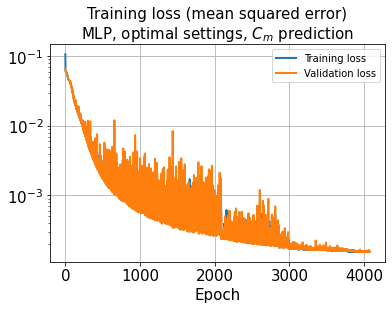

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

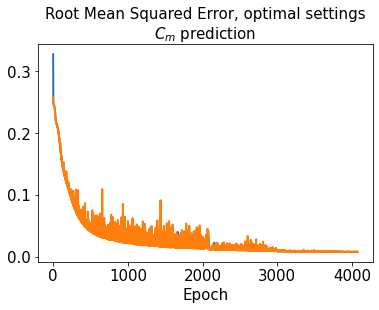

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

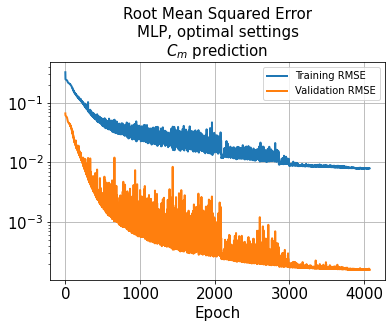

In [36]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [37]:
train_results = model.evaluate(x_train, y_train)

1094/1094 [==============================] - 4s 3ms/step - loss: 1.5452e-04 - rmse: 0.0079


In [38]:
val_results = model.evaluate(x_val, y_val)

313/313 [==============================] - 1s 3ms/step - loss: 1.5700e-04 - rmse: 0.0080


In [39]:
test_results = model.evaluate(x_test, y_test)

157/157 [==============================] - 0s 3ms/step - loss: 1.5733e-04 - rmse: 0.0081


In [40]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

157/157 [==============================] - 0s 1ms/step


In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [45]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.017669013697593425
0.6611749434875536


In [47]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.018140590033952533
0.6911952448750336


In [48]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.01809605109152848
0.6805907054288661


In [49]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [50]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [51]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_10h(re)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [52]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [53]:
os.chdir(storage_dir)

In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

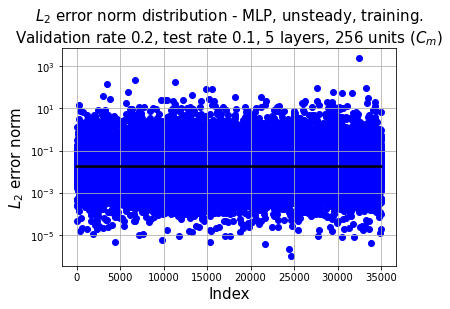

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

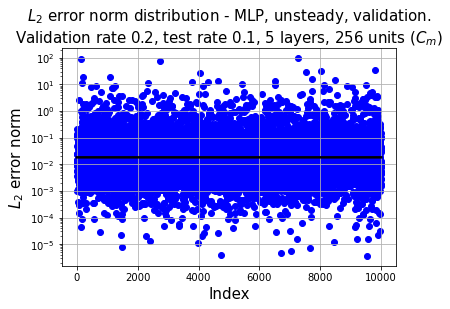

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

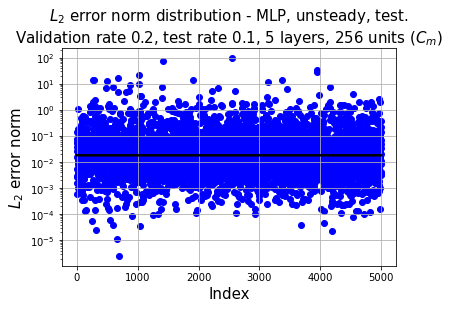

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

1563/1563 [==============================] - 2s 1ms/step


In [65]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [66]:
index_train.shape

(35000,)

In [67]:
max(predicted)

array([1.0052824], dtype=float32)

In [68]:
l2_error(denormalize(predicted), denormalize(y))

0.02459991591890513

In [69]:
l2_error(predicted, y)

0.01780623520260968

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
x[:,0] *= 5
x[:,0] += 10

In [77]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0120


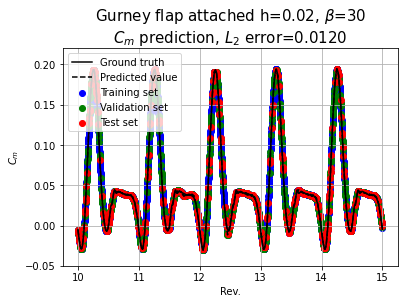

L2 error of Cm: 0.0127


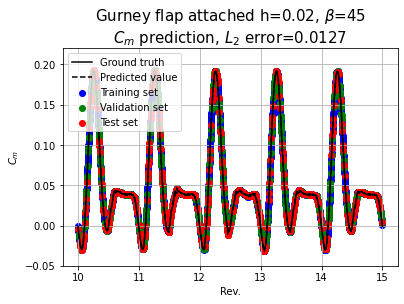

L2 error of Cm: 0.0121


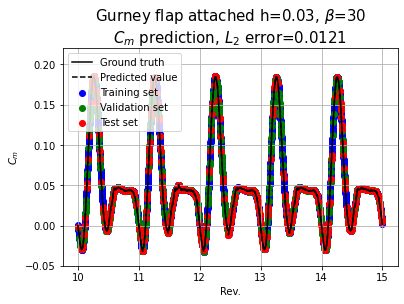

L2 error of Cm: 0.0112


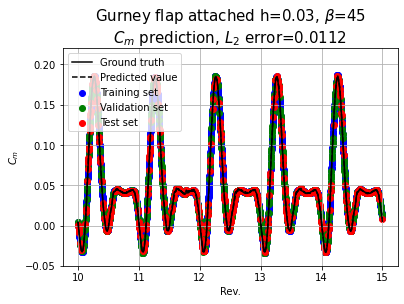

L2 error of Cm: 0.0101


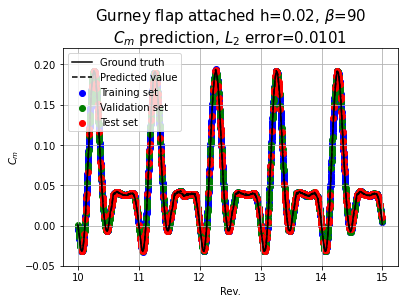

L2 error of Cm: 0.0147


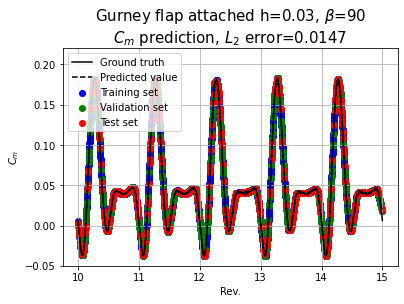

L2 error of Cm: 0.0242


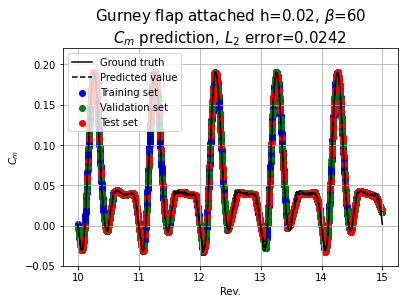

L2 error of Cm: 0.0311


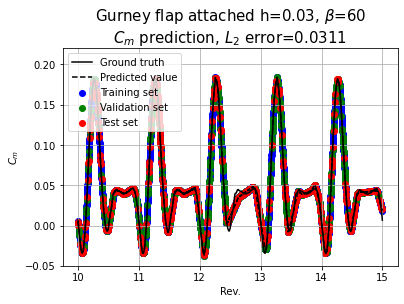

L2 error of Cm: 0.0169


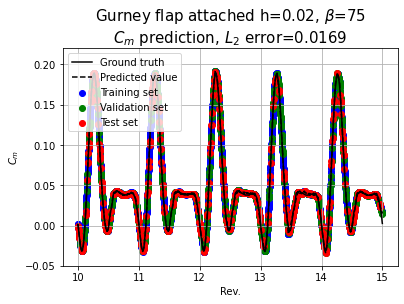

L2 error of Cm: 0.0217


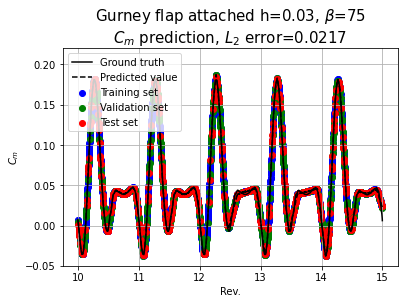

In [78]:
h = [0.02, 0.02, 0.03, 0.03,0.02, 0.03, 0.02, 0.03, 0.02, 0.03]
beta = [30, 45, 30, 45, 90, 90, 60, 60, 75, 75]
for i in range(0,10):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [79]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
#     title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0120


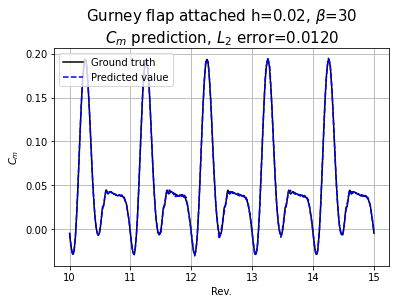

L2 error of Cm: 0.0127


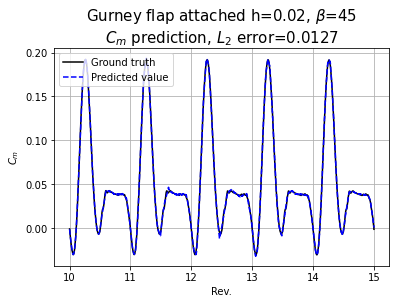

L2 error of Cm: 0.0121


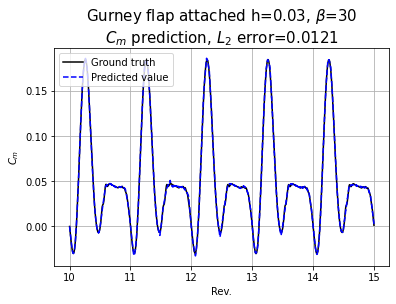

L2 error of Cm: 0.0112


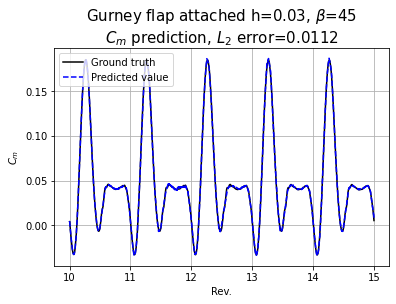

L2 error of Cm: 0.0101


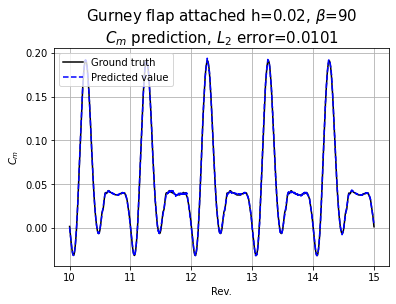

L2 error of Cm: 0.0147


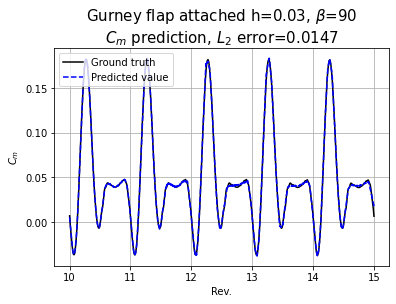

L2 error of Cm: 0.0242


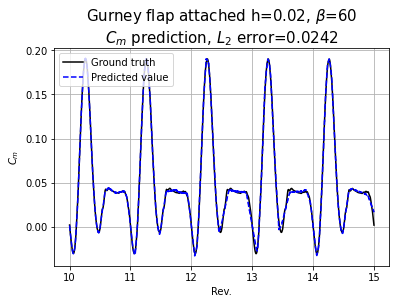

L2 error of Cm: 0.0311


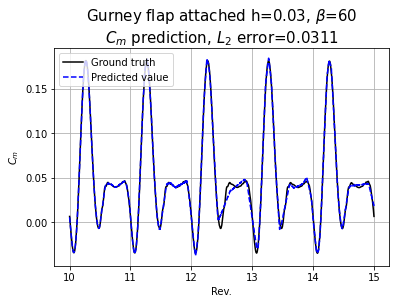

L2 error of Cm: 0.0169


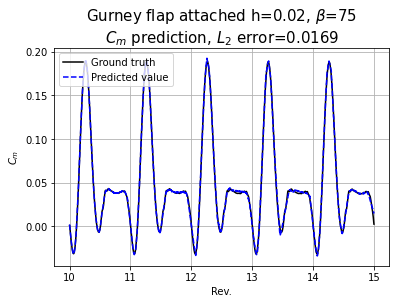

L2 error of Cm: 0.0217


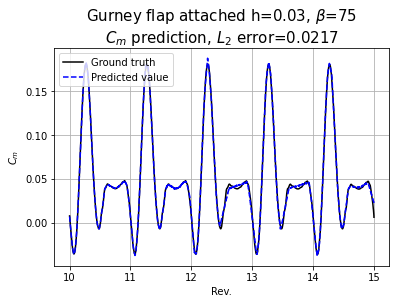

In [80]:
for i in range(0,10):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0120


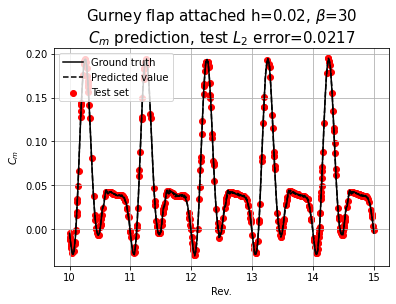

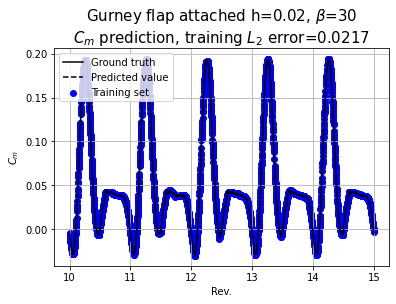

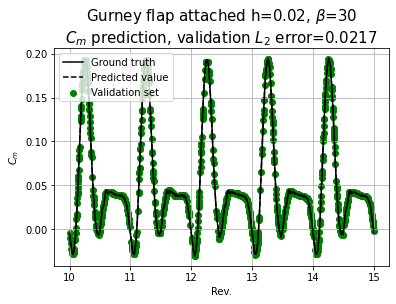

L2 error of Cm: 0.0127


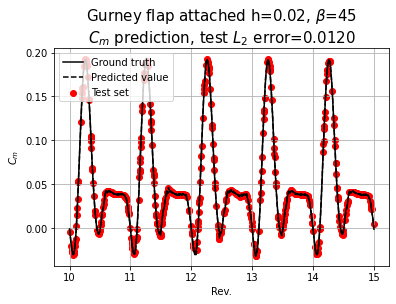

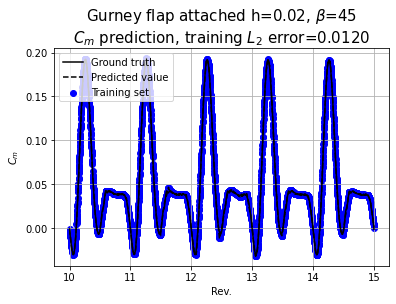

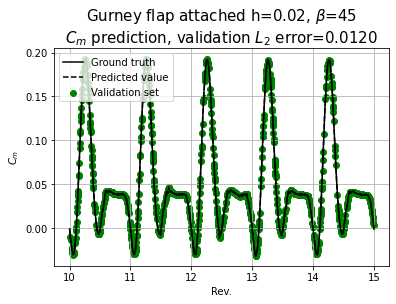

L2 error of Cm: 0.0121


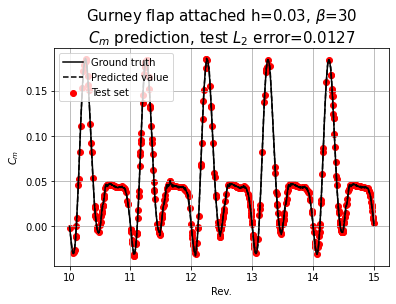

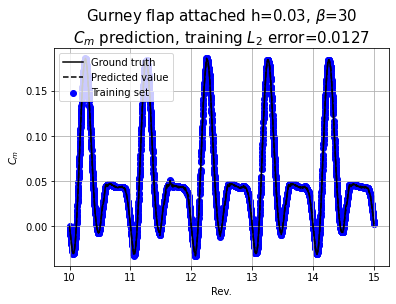

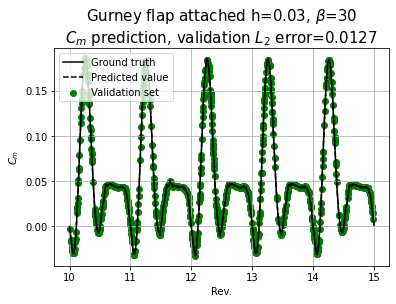

L2 error of Cm: 0.0112


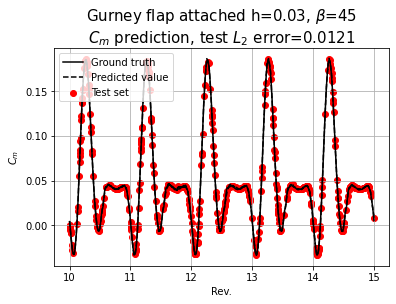

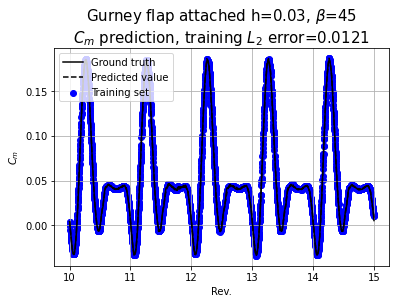

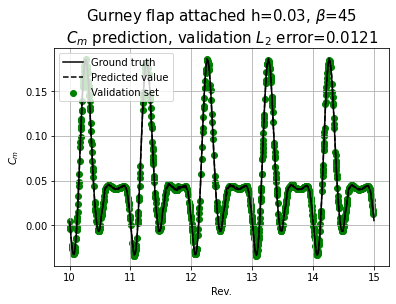

L2 error of Cm: 0.0101


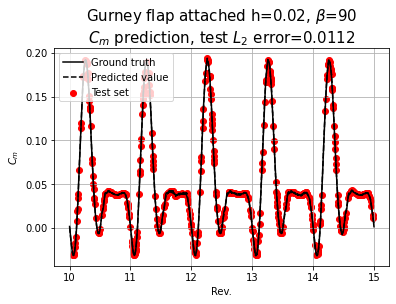

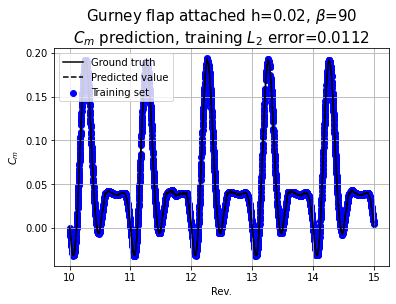

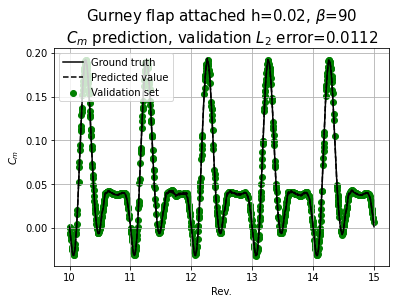

L2 error of Cm: 0.0147


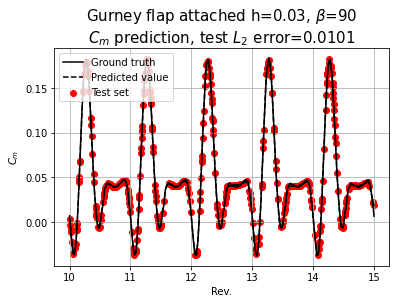

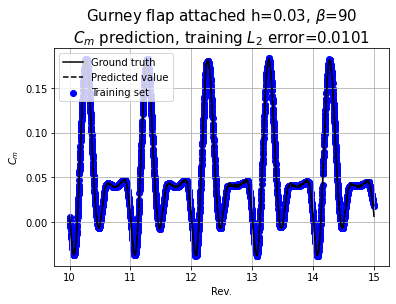

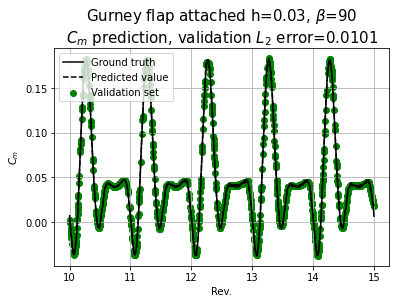

L2 error of Cm: 0.0242


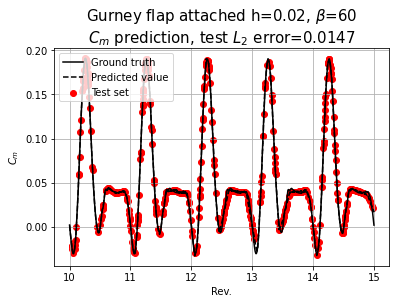

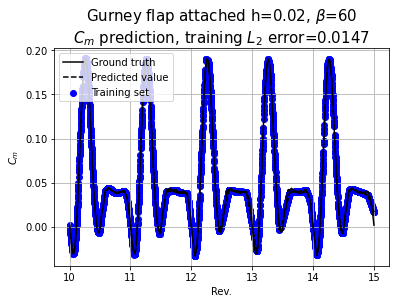

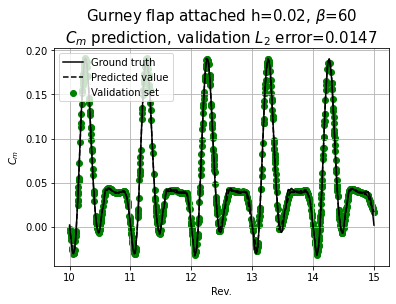

L2 error of Cm: 0.0311


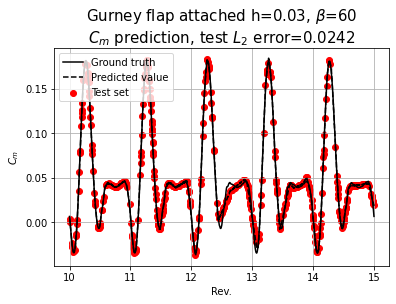

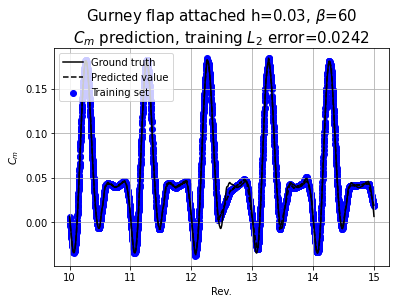

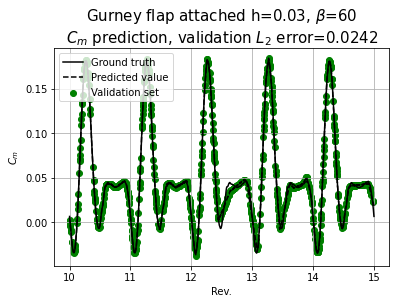

L2 error of Cm: 0.0169


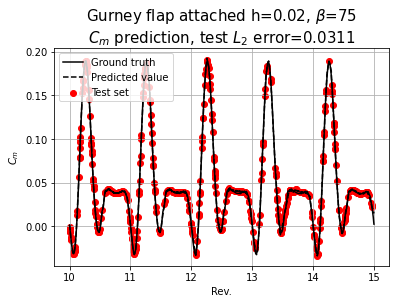

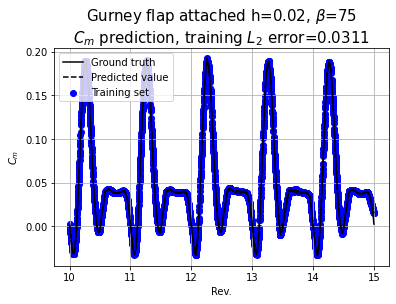

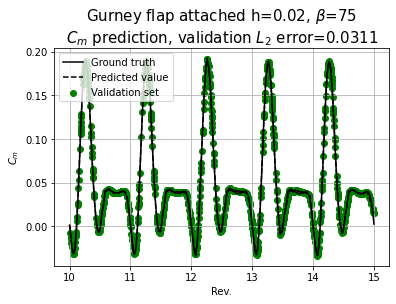

L2 error of Cm: 0.0217


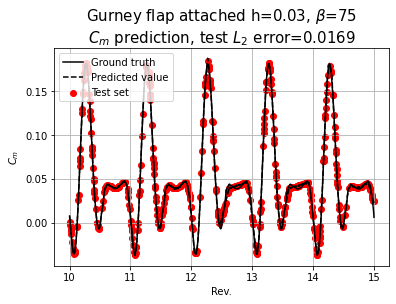

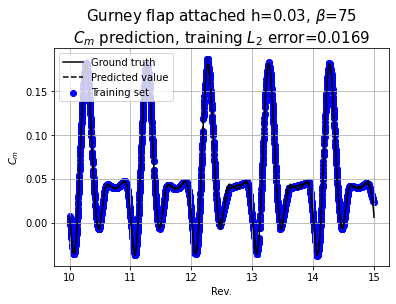

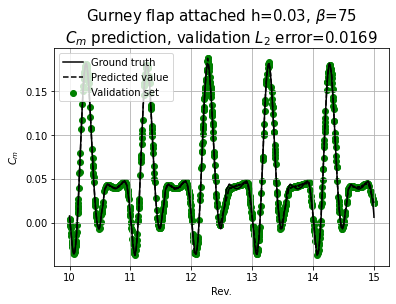

In [83]:
for i in range(0,10):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    title_train = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_Cm)
    title_val = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_Cm)
    title_test = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_Cm)

    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_test, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_train, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_val, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()